In [ ]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [ ]:
#Read the daily city-wise data
df= pd.read_csv("/content/city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [ ]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


In [ ]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [ ]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [ ]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

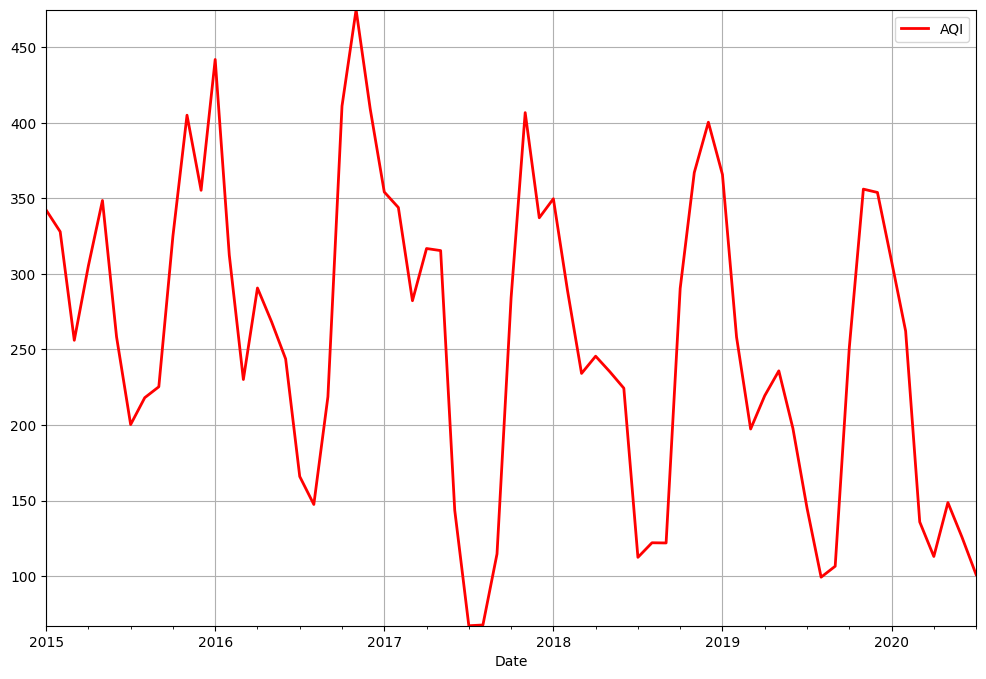

In [ ]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

# FORECASTING


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

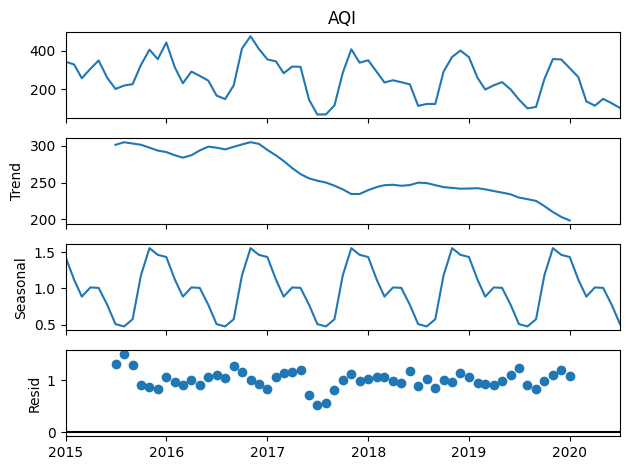

In [ ]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

# **SARIMAX MODEL**

In [ ]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
len(delhi_AQI)

67

In [ ]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [ ]:
!pip install pmdarima;
from pmdarima import auto_arima;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00


In [ ]:
auto_arima(y=delhi_AQI,start_p=1,start_P=1,start_q=1,start_Q=1,seasonal=True,m=12, stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   67
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                -350.239
Date:                             Mon, 13 May 2024   AIC                            712.478
Time:                                     13:31:41   BIC                            725.707
Sample:                                 01-01-2015   HQIC                           717.713
                                      - 07-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.8378     12.462      1.351      0.177      -7.588      41.263
ar.L1          0.5809      0.148      3.917      0.000       0.290       0.872
ma.L1          0.2479      0.176      1.408      0.159      -0.097       0.593
ar.S.L12       0.3038      0.115      2.643      0.008       0.078       0.529
ar.S.L24       0.5384      0.137      3.942      0.000       0.271       0.806
sigma2      1606.4064    378.789      4.241      0.000     863.995    2348.818
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.99   Prob(JB):                         1.00
Heteroskedasticity (H):               0.73   Skew:                             0.01
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(1,0,1),seasonal_order=(2,0,[],12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 AQI   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                -258.442
Date:                             Tue, 14 May 2024   AIC                            526.885
Time:                                     13:43:36   BIC                            536.241
Sample:                                 01-01-2015   HQIC                           530.420
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8680      0.080     10.886      0.000       0.712       1.024
ma.L1          0.1395      0.226      0.617      0.537      -0.303       0.583
ar.S.L12       0.1783      0.104      1.709      0.087      -0.026       0.383
ar.S.L24       0.7282      0.119      6.126      0.000       0.495       0.961
sigma2      1595.8647    485.288      3.288      0.001     644.719    2547.011
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.90   Prob(JB):                         0.92
Heteroskedasticity (H):               1.07   Skew:                            -0.11
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

<Axes: xlabel='Date'>

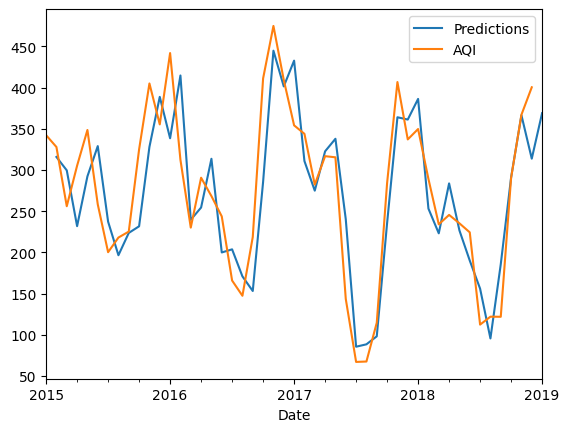

In [ ]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [ ]:
#Calculating the RMSE value on the training dataset
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  53.82537020821191
Mean AQI 275.1711046334552


<Axes: xlabel='Date'>

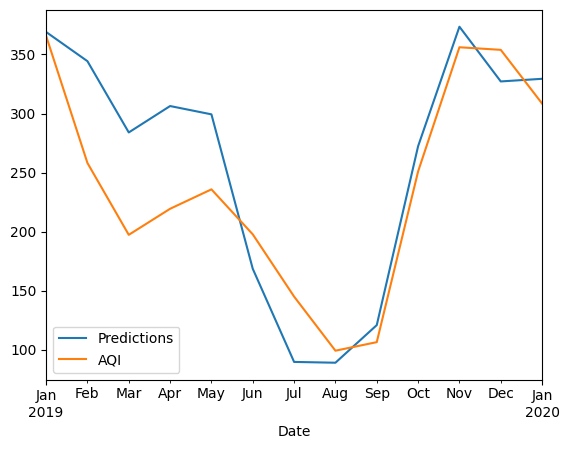

In [ ]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [ ]:
#Calculating the RMSE value on the testing dataset
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  50.1232129108282
Mean AQI 238.0504608294931


<Axes: xlabel='Date'>

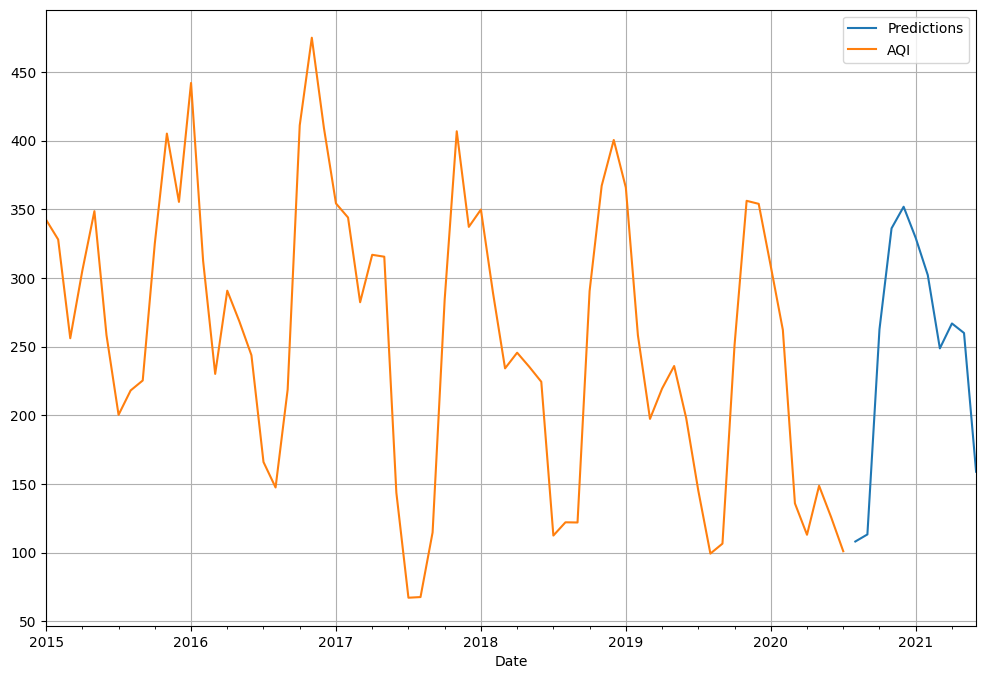

In [ ]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)